# TEXT CLASSIFICATION

In this assignment, you will

1. Download text (the IMDB reviews dataset).
1. Process it; vectorize it.
1. Perform parameter selection (for logistic regression) using cross validation on the train split.
1. Train a model using the best parameter setting.
1. Report the top positive and negative features and discuss your findings.
1. Evaluate the model on the test split. Report performance metrics.
1. Choose a few random test documents.
1. Print the top positive and negative words in those documents.
1. Discuss your findings.

**Name**: Jane Downer <br>
**CWID**: A20452471 <br>
**Section**: 02 <br>

In [1]:
!cd  /opt/anaconda3/envs/venv_581
# !pip install matplotlib
# !pip install nltk
# !pip install pandas
# !pip install scikit-learn
# !pip install seaborn
# !pip install tqdm
import copy
from   IPython.display import display_html 
import matplotlib.pyplot as plt
import nltk
from   nltk import corpus, WordNetLemmatizer
from   nltk.corpus import stopwords
nltk.download(['stopwords','wordnet','omw-1.4'], quiet=True)

import numpy as np
import os
import pandas as pd
from   pandas import DataFrame as df
import random
import re
import seaborn as sns
import sklearn
from   sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from   sklearn.linear_model import LogisticRegression
from   sklearn.model_selection import GridSearchCV, learning_curve

import tqdm
from   tqdm import tqdm

## Dataset

The IMDB review dataset is available via different platforms. We will work with the "raw" text version of it.

Download the dataset from https://ai.stanford.edu/~amaas/data/sentiment/.

Unzip it; put it into a folder called ``aclImdb`` (case senstive). The ``aclImdb`` folder should be in the same folder as this notebook. The folder structure should look like this:

``aclImdb`` <br>
-> ``train`` <br>
---> ``neg`` <br>
---> ``pos`` <br>
-> ``test`` <br>
---> ``neg`` <br> 
---> ``pos`` <br>

You can ignore the other folders.

The files in the ``train`` folder are train documents and the ``test`` are, well, the test documents. The documents in ``neg`` are negative documents and the documents in ``pos`` are the positive documents.

Load the documents and their labels.

In [2]:
dir_ = '/Users/janedowner/Desktop/CS 581/CS 581 - Assignment 4'
os.chdir(dir_)

train = {'File #':[], 'Document': [],'Label':[]}
test  = {'File #':[], 'Document': [],'Label':[]}

def build_dict(dictionary,folder_extension, label):
    folder = os.listdir(dir_ + folder_extension)
    for file in folder:
        with open(dir_ + folder_extension + file) as f:
            dictionary['File #']  .append(file[:-4])
            dictionary['Document'].append(''.join(f.readlines()))
            dictionary['Label']   .append(label)

build_dict(train,'/aclImdb/train/pos/',1)
build_dict(train,'/aclImdb/train/neg/',0)
build_dict(test, '/aclImdb/test/pos/', 1)
build_dict(test, '/aclImdb/test/neg/', 0)

train_df = pd.DataFrame(train).sample(frac=1).reset_index(drop=True)
test_df  = pd.DataFrame(test) .sample(frac=1).reset_index(drop=True)

In [3]:
def compose(functions, input_):
    while len(functions) > 0:
        inner_most = functions[-1]
        input_     = inner_most(input_)
        functions  = functions[:-1]
    output = input_
    return output

sw       = stopwords.words('english')
lower    = lambda doc: ''.join([w.lower() for w in doc])
no_hyph  = lambda doc: re.sub(r'-',' ',doc)
no_punct = lambda doc: ''.join([w for w in doc if w.isalpha() or w == ' '])
tok      = lambda doc: doc.split()
no_sw    = lambda doc: [w for w in doc if w not in sw]
lemm     = lambda doc: [WordNetLemmatizer().lemmatize(w) for w in doc]

prep_row = lambda df,row: ' '.join(compose([lemm,
                                            no_sw,
                                            tok,
                                            no_punct,
                                            no_hyph,
                                            lower],df.iloc[row,1]))

train_df_preprocessed = train_df.copy()
test_df_preprocessed  = test_df .copy()
for row in tqdm(range(len(train_df))):
    train_df_preprocessed.iloc[row,1] = prep_row(train_df_preprocessed,row)
    test_df_preprocessed .iloc[row,1] = prep_row(test_df_preprocessed,row)

train_df_preprocessed.to_csv('train_df - preprocessed', index=False)
test_df_preprocessed .to_csv('test_df - preprocessed',  index=False)

100%|████████████████████████████████████| 25000/25000 [00:50<00:00, 495.02it/s]


## Vectorization

You must use the scikit-learn package for vectorization and for the classifier: https://scikit-learn.org/stable/index.html

You have freedom regarding the vectorizer: https://scikit-learn.org/stable/modules/classes.html#module-sklearn.feature_extraction.text You can use the `CountVectorizer` or the `TfidfVectorizer` with parameters of your choice.

In [4]:
train_df_preprocessed = pd.read_csv(filepath_or_buffer='train_df - preprocessed', 
                                    index_col         = False)
test_df_preprocessed  = pd.read_csv(filepath_or_buffer='test_df - preprocessed',  
                                    index_col         = False)
X_train               = train_df_preprocessed.iloc[:,1]
X_test                = test_df_preprocessed .iloc[:,1]
y_train               = train_df_preprocessed.iloc[:,2]
y_test                = test_df_preprocessed .iloc[:,2]

TFIDF                 = TfidfVectorizer()

X_all                 = pd.concat([X_train,X_test],keys=['X_train','X_test'])
BOW_all               = TFIDF.fit_transform(X_all)
train_indices         = range(len(X_train))
test_indices          = range(len(X_train),len(X_train)+len(X_test))
BOW_train             = BOW_all[train_indices,:]
BOW_test              = BOW_all[test_indices, :]
BOW_train_norm        = sklearn.preprocessing.normalize(BOW_train, 
                                                        norm='l2', 
                                                        return_norm=False)
BOW_test_norm         = sklearn.preprocessing.normalize(BOW_test,  
                                                        norm='l2', 
                                                        return_norm=False)

## Parameter Selection

For the classifier, you must use `LogisticRegression`: https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html

Use 10-fold cross validation using various parameter settings for `C`. Please use `penalty='l2'`. You can use any solver; the results should not change drastically based on the solver; I do not recommend spending a lot of time on trying different solvers.

I recommend using https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html. Report the grid search results using a table.

In [5]:
param_grid = {'penalty': ['l2'],
              'C':       [1.0,5.0,10.0],
              'tol':     [0.0001,0.01,0.1],
              'solver':  ['liblinear']}

LR_model = LogisticRegression()
grid_clf = GridSearchCV(estimator=LR_model,
                        cv=10,
                        param_grid=param_grid,
                        refit=True,
                        return_train_score=True)

grid_clf.fit(BOW_train_norm,y_train)

best_params = df(grid_clf.cv_results_)[['mean_fit_time',
                                        'params',
                                        'mean_train_score']]

best_params.to_csv(dir_ + '/aclImdb/best_params')
pd.set_option("display.max_colwidth",100)
display(best_params)

,mean_fit_time,params,mean_train_score
0,1.386041,"{'C': 1.0, 'penalty': 'l2', 'solver': 'liblinear', 'tol': 0.0001}",0.936093
1,0.863272,"{'C': 1.0, 'penalty': 'l2', 'solver': 'liblinear', 'tol': 0.01}",0.936187
2,0.648403,"{'C': 1.0, 'penalty': 'l2', 'solver': 'liblinear', 'tol': 0.1}",0.934929
3,2.127197,"{'C': 5.0, 'penalty': 'l2', 'solver': 'liblinear', 'tol': 0.0001}",0.978658
4,1.508836,"{'C': 5.0, 'penalty': 'l2', 'solver': 'liblinear', 'tol': 0.01}",0.978609
5,5.683586,"{'C': 5.0, 'penalty': 'l2', 'solver': 'liblinear', 'tol': 0.1}",0.978449
6,2.564791,"{'C': 10.0, 'penalty': 'l2', 'solver': 'liblinear', 'tol': 0.0001}",0.991320
7,1.754672,"{'C': 10.0, 'penalty': 'l2', 'solver': 'liblinear', 'tol': 0.01}",0.991262
8,1.430334,"{'C': 10.0, 'penalty': 'l2', 'solver': 'liblinear', 'tol': 0.1}",0.991609


#### The following parameters maximize mean training score, while resulting in lower mean fit time than parameters with comparable scores:

 `C: 10.0`<br>`penalty: l2`<br>`solver: liblinear`<br>`tol: 0.1`

## Refit

Fit a logistic regression on the full training data using the best parameter settings above.

In [6]:
LR_model = LogisticRegression(C=10.0,
                              penalty='l2',
                              solver='liblinear',
                              tol=0.1)
LR_model.fit(BOW_train_norm,y_train)

LogisticRegression(C=10.0, solver='liblinear', tol=0.1)

## Top Model Features

Present a table of top 20 positive features (the feature names and their coefficients) and another table of top 20 negative features, with respect to the logistic regression weights.

In [7]:
coefs       = LR_model.coef_[0]
###
idxs_pos20  = np.argpartition(coefs, -20)[-20:]
idxs_neg20  = np.argpartition(coefs,  20)[: 20]
###
feats_pos20 = TFIDF.get_feature_names_out()[idxs_pos20]
feats_neg20 = TFIDF.get_feature_names_out()[idxs_neg20]
###
coefs_pos20 = coefs[idxs_pos20]
coefs_neg20 = coefs[idxs_neg20]

fts_df  = lambda fts,cfs,cols: df({cols[0]:fts,cols[1]:cfs})
sort_df = lambda df,cols,asc: df.sort_values(by=cols[1],
                                             ascending=asc).reset_index(drop=1)

cols_=['Feature','Coefficient']
featsDF_pos = sort_df(fts_df(feats_pos20,coefs_pos20,cols_),cols_,0)
featsDF_neg = sort_df(fts_df(feats_neg20,coefs_neg20,cols_),cols_,1)

dfL_ = featsDF_pos.style.set_table_attributes("style='display:inline'")
dfL_ = dfL_.set_caption('Top 20 Positive Features')
dfR_ = featsDF_neg.style.set_table_attributes("style='display:inline'")
dfR_ = dfR_.set_caption('Top 20 Negative Features')

space = "\xa0" * 10
display_html(dfL_._repr_html_() + space + dfR_._repr_html_(), raw=True)

,Feature,Coefficient
0,excellent,10.713445
1,great,9.763227
2,perfect,8.997792
3,favorite,8.383455
4,highly,7.663079
5,wonderful,7.643704
6,best,7.557310
7,superb,7.362319
8,amazing,7.125742
9,refreshing,7.075560


## Evaluation

Print a classification report on the train and another classification report on the test. Discuss your findings.

In [8]:
y_pred_train = LR_model.predict(BOW_train_norm)
y_pred_test  = LR_model.predict(BOW_test_norm)

train_report = sklearn.metrics.classification_report(y_train,
                                                     y_pred_train,
                                                     digits=2,
                                                     zero_division='warn')

test_report  = sklearn.metrics.classification_report(y_test,
                                                     y_pred_test,
                                                     digits=2,
                                                     zero_division='warn')

print('Classification Report -- training data:\n{}'.format(train_report))
print('Classification Report -- testing data:\n{}' .format(test_report))

Classification Report -- training data:
              precision    recall  f1-score   support

           0       0.99      0.99      0.99     12500
           1       0.99      0.99      0.99     12500

    accuracy                           0.99     25000
   macro avg       0.99      0.99      0.99     25000
weighted avg       0.99      0.99      0.99     25000

Classification Report -- testing data:
              precision    recall  f1-score   support

           0       0.86      0.88      0.87     12500
           1       0.88      0.86      0.87     12500

    accuracy                           0.87     25000
   macro avg       0.87      0.87      0.87     25000
weighted avg       0.87      0.87      0.87     25000



***
***
#### The classifier performs better on the training data than on the testing data. This makes sense to a degree, because the classifier has complete information about the training data, but not the testing data. However, it might be an indicator of overfitting, or some other issue. I will discuss this more later.

#### High accuracy by itself doesn't mean very much without these other scores to back it up, especially when there is class imbalance. However, within each classification report, these scores are similar to eachother and to accuracy. Moreover, there are an equal number of positive and negative samples anyway. Given this scenario, it is appropriate to consider the accuracy scores.
***
***

## Top Features In Each Document

Pick a few (at least 3) documents at random. For each document:
1. Print the document.
1. Print its label.
1. Present a a table of top 10 positive features (in that document), their weights, and their weights*feature values.
1. Present a a table of top 10 negative features (in that document), their weights, and their weights*feature values.


Note: if your vectorizer is binary, you weigths and weights*feature should be the same.

In [9]:
'''
I wasn't sure whether the question was asking to choose documents
from the training or testing data (or both). These docuents come
from the testing data.
''' 
keys_    = lambda dict_: list(dict_.keys())
vals_    = lambda dict_: list(dict_.values())
items_   = lambda dict_: list(dict_.items()) 
list_zip = lambda L1,L2: list(zip(L1,L2))

random_indices  = random.sample(range(len(test_df_preprocessed)),5)
random_data     = test_df_preprocessed.iloc[random_indices,:].reset_index(drop=True)
random_docs_raw = test_df.iloc[random_indices,1].tolist()
random_BOW      = BOW_test_norm.toarray()[random_indices,:]


weights_list_pos, weights_list_neg = [],[]
values_list_pos,  values_list_neg  = [],[]
all_feats = TFIDF.get_feature_names_out().tolist()
for i in range(len(random_data)):
    lab = random_data.iloc[i,2]
    feats_idx   = [idx for idx in range(len(random_BOW[i])) if random_BOW[i][idx] != 0]
    feats       = [all_feats[idx] for idx in feats_idx]
    feats_coefs = [coefs[idx] for idx in feats_idx]
    feats_vals  = [random_BOW[i][idx] for idx in feats_idx]

    items = sorted(list_zip(feats,
                            feats_coefs),
                   key=lambda item: item[1],
                   reverse=True)
    
    pos_items, neg_items = items[:10], items[-10:]
    pos_feats, neg_feats = keys_(dict(items))[:10], keys_(dict(items))[-10:]
    
    weights_pos = {k:v for (k,v) in pos_items}
    weights_neg = {k:v for (k,v) in neg_items}

    values     = {k:v for (k,v) in list_zip(feats, feats_vals)}
    values_pos = {k:v for (k,v) in items_(values) if k in pos_feats}
    values_neg = {k:v for (k,v) in items_(values) if k in neg_feats}
    weights_list_pos.append(weights_pos)
    weights_list_neg.append(weights_neg)
    values_list_pos .append(values_pos)
    values_list_neg .append(values_neg)


w_x_v = lambda weights,values,i: [w*v for (w,v) in zip(vals_(weights[i]),
                                                       vals_(values[i]))]
    
for i in range(5):
    sub_file = 'pos' if random_data.Label[i]==1 else 'neg'
    print('~/test/{}/{}:\n'.format(sub_file, random_data.iloc[i,:]["File #"]))
    print(random_docs_raw[i])
    df_pos = df({'Feature':      keys_(weights_list_pos[i]),
                 'Weight':       vals_(weights_list_pos[i]),
                 'Weight*Value': w_x_v(weights_list_pos, values_list_pos,i)})

    df_neg = df({'Feature':      keys_(weights_list_neg[i]),
                 'Weight':       vals_(weights_list_neg[i]),
                 'Weight*Value': w_x_v(weights_list_neg, values_list_neg, i)})

    dfL_ = df_pos.style.set_table_attributes("style='display:inline'")
    dfL_ = dfL_.set_caption('Top 10 Positive Features')
    dfR_ = df_neg.style.set_table_attributes("style='display:inline'")
    dfR_ = dfR_.set_caption('Top 10 Negative Features')
    space = "\xa0" * 10
    display_html(dfL_._repr_html_() + space + dfR_._repr_html_(), raw=True)

    true_label = random_data.Label[i]
    pred_label = y_pred_test[random_indices[i]]
    sums_pos = round(sum(df_pos['Weight*Value']),3)
    sums_neg = round(sum(df_neg['Weight*Value']),3)
    
    print('True label:      {}'.format('POSITIVE' if true_label==1 else 'NEGATIVE'))
    print('Predicted label: {}'.format('POSITIVE' if pred_label==1 else 'NEGATIVE'))
    print('Sum(weights*values) of the features above: {}'.format(sums_pos+sums_neg))
    print('\n\n')

~/test/neg/1053_4:

Most Lorne Michaels films seem to fail because they're essentially just extended versions of skits that barely managed to make people laugh in five-minute segments. "Tommy Boy" is a character right from "SNL" - a big fat lovable (in their opinion) goof who doesn't know anything.<br /><br />David Spade gets the Thankless Overwhelmed Everyman role. He's paired with the Annoying Overweight Slob and they endure Miserable Misfortunes as they travel cross country to Save Daddy's Business.<br /><br />The plot, for starters, is really faulty. The whole premise - daddy dies and rich stupid son has to save the family biz - can be traced back to just about any movie you want. Like any SNL style film it is reduced to a simple motivation - empty, shallow; just a reason to see a fat guy and a thin guy be "funny" together.<br /><br />The movie's biggest "influence" is the 1987 comedy classic "Planes, Trains & Automobiles." That movie is great because the plot isn't stale and recyc

,Feature,Weight,Weight*Value
0,great,9.763227,0.502943
1,enjoyed,6.569295,0.317609
2,simple,4.777892,0.183258
3,classic,4.413306,0.200593
4,believable,3.629697,0.239013
5,see,3.420720,0.146622
6,eerie,3.394600,0.084096
7,cool,3.276795,0.108443
8,right,3.195455,0.069656
9,appreciate,3.113110,0.278466


True label:      NEGATIVE
Predicted label: NEGATIVE
Sum(weights*values) of the features above: -0.7480000000000002



~/test/pos/5695_10:

BLACK WATER is a thriller that manages to completely transcend it's limitations (it's an indie flick) by continually subverting expectations to emerge as an intense experience.<br /><br />In the tradition of all good animal centered thrillers ie Jaws, The Edge, the original Cat People, the directors know that restraint and what isn't shown are the best ways to pack a punch. The performances are real and gripping, the crocdodile is extremely well done, indeed if the Black Water website is to be believed that's because they used real crocs and the swamp location is fabulous.<br /><br />If you are after a B-grade gore fest croc romp forget Black Water but if you want a clever, suspenseful ride that will have you fearing the water and wondering what the hell would I do if i was up that tree then it's a must see.


,Feature,Weight,Weight*Value
0,best,7.557310,0.392156
1,well,6.231693,0.619490
2,ride,4.105707,0.158641
3,manages,3.944566,0.473768
4,good,3.640288,0.383272
5,see,3.420720,0.324552
6,intense,3.283365,0.326474
7,suspenseful,2.972616,0.122031
8,edge,2.969616,0.343430
9,gripping,2.525904,0.109914


True label:      POSITIVE
Predicted label: POSITIVE
Sum(weights*values) of the features above: 0.6230000000000002



~/test/neg/4057_4:

It is amazing what you can see if you wake at 2 am and turn on the telly. I didn't know they showed films like this. I immediately thought of Roger Corman, who reused locations for movies or used other films locations for his own movies.<br /><br />The makes of this film could just move the camera angles and add some time and they would have an XXX film.<br /><br />There was no story, just minimum dialog that led to stripping and sex. I bet there wasn't 100 words in the whole film, but there sure was a lot of very large busts and hot lesbian action. There was male/female action too, but it was only about 25% of the movie.<br /><br />Another interesting thing came to mind in watching this film that may interest those who are buying hi def DVDs. Sony refused to license Betamax to adult film makers and adult films came out on VHS. You can guess what happ

,Feature,Weight,Weight*Value
0,amazing,7.125742,0.763909
1,deal,3.728409,0.249815
2,vhs,3.435878,0.238287
3,see,3.420720,0.195213
4,lot,3.414416,0.261379
5,time,2.902021,0.134016
6,dvd,2.794541,0.145733
7,may,2.696600,0.090954
8,action,2.247620,0.069648
9,hot,2.138861,0.191611


True label:      NEGATIVE
Predicted label: POSITIVE
Sum(weights*values) of the features above: 0.15100000000000025



~/test/neg/10609_1:

So, it's Friday night and you want to go watch a movie...all you want is something entertaining, not too artsy, or anything that might require a long night of philosophical discussions. So, you pay $10 to watch the Mod Squad. The trailer to this movie should have tipped me off, but come on...it's three of Hollywood's most beautiful people--eye candy. But that's about it...a string of moving Prada ads. And what did Hollywood producers forget? A plot. Why are these kids running around the streets after some unknown enemy? Where are they? But, don't worry, after a while, you'll just stop caring. I was on the verge of walking out of this movie, because I thought sitting in my room and staring at the wall might have been more productive (and free), but by that time, it was over (90 minutes--it's only saving grace). So, still willing to waste $10? Go, get

,Feature,Weight,Weight*Value
0,entertaining,6.190200,0.493475
1,still,4.758718,0.410372
2,moving,4.569449,0.369561
3,beautiful,3.993864,0.413424
4,nice,3.657173,0.355705
5,time,2.902021,0.235905
6,trailer,2.349717,0.140948
7,hot,2.138861,0.089623
8,watch,2.084473,0.237044
9,eye,2.043611,0.224313


True label:      NEGATIVE
Predicted label: NEGATIVE
Sum(weights*values) of the features above: -0.492



~/test/pos/11517_8:

Lights of New York was the first all-talking feature film. There had been, of course, The Jazz Singer, released in Oct. 1927 as the first feature film incorporating synchronized dialog. However, this film released in July 1928 is virtually unremembered for its place in film history. It had started out as a short, but gradually more was tacked on until - clocking in at 58 minutes - it accidentally became the first all-talking feature film. It opened to a grind house run and to Warner Bros. surprise, made over a million dollars. That was good money back in 1928.<br /><br />The plot is quite simple. Two country barbers naively buy into a barber shop on Broadway that fronts as a speak-easy for "The Hawk", a gangster. When they learn the truth they can't afford to get out, because the younger barber, Eddie, has all of his mother's money tied up in the place. Kitty is

,Feature,Weight,Weight*Value
0,loved,6.679158,0.198570
1,fun,6.112624,0.418368
2,simple,4.777892,0.123752
3,still,4.758718,0.126260
4,kitty,4.327683,0.630010
5,ride,4.105707,0.107286
6,easy,3.953185,0.131746
7,good,3.640288,0.150261
8,see,3.420720,0.096567
9,heart,3.348762,0.181797


True label:      POSITIVE
Predicted label: POSITIVE
Sum(weights*values) of the features above: 0.722





## Final Discussion

Discuss your findings.

## 1.

### Do you think your model is accurate, based on classification metrics?

#### When considered simultaneously, precision, recall and F1 can give a more holistic representation of model performance than just an accuracy score alone. As we saw above, they are all between 0.86 and 0.88, which is decent, but not perfect. Another way to represent the model performance is with the ROC (receiver operator characteristic) -- which shows the tradeoff between false positive rates and true positive rates -- and AUC  (area under the ROC curve).

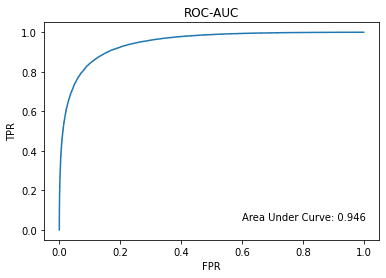

In [10]:
y_pred_prob = LR_model.predict_proba(BOW_test_norm)
y_          = y_test.tolist()
y_          = np.asarray([[0,1] if y == 1 else [1,0] for y in y_])
fpr, tpr, _ = sklearn.metrics.roc_curve(y_.ravel(), y_pred_prob.ravel())
auc         = round(sklearn.metrics.auc(fpr,tpr),3)

plt.plot(fpr,tpr)
plt.title('ROC-AUC')
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.annotate("Area Under Curve: {}".format(auc),xy=[0.6,0.05])
plt.show()


#### A perfect classifier will have an area under the curve value of 1. Here, it's 0.946, which is pretty good. Moreover, the fact that the curve is pulled toward the upper left-hand corner means that at certain threshold levels, the model can achieve high true positive rates without much of an increase in false positive rates. This is what we want.
#### The confusion matrix can also provide us with information about model accuracy:

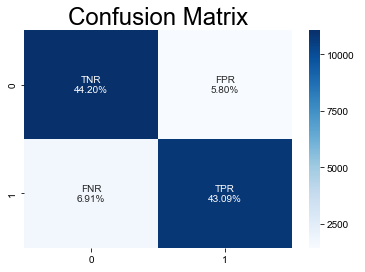

In [11]:
cm     = sklearn.metrics.confusion_matrix(y_test,y_pred_test)
grps   = ['TNR','FPR','FNR','TPR']
pcts   = ["{0:.2%}".format(val) for val in cm.flatten()/np.sum(cm)]
labels = np.asarray(["{}\n{}".format(g,p) for (g,p) in zip(grps,pcts)]).reshape(2,2)

sns.heatmap(cm,annot=labels,fmt='',cmap=sns.color_palette("Blues",as_cmap=True))
sns.set(font_scale = 2)
plt.title('Confusion Matrix')
plt.show()

#### The confusion matrix shows that false negatives and false positive occur at rates of 6.91% and 5.80%.  In other words, the model guesses incorrectly 6.91+5.80=12.71% of the time. This is acceptable, but could be better.
#### All of the above classification metrics suggest that the model is acceptably accurate.

## 2.

### Do you think your model is smart? Answer this question solely based on the classification accuracy.
#### The model accuracy is 0.87, which is decent. Based on this number alone, the model seems relatively smart, or at the very least, does its job. However, as I've explained above, accuracy by itself doesn't provide a holistic view of model performance.

## 3.

### Do you think your model is smart? Answer this question solely based on top features in each document.
#### Some of the top features in each document make sense, and others do not. In my opinion, the top features of these individual documents provide the strongest evidence that the model is *not* smart.
#### For example, there is no apparent reason why these words should be associated with positive labels:

`eerie`<br>
`kitty`<br>
`ride`<br>
`see`<br>

#### ... Or why these words should be associated with negative labels:

`artsy`<br>
`croc`<br>
`grade`<br>
`three`<br>
`tree`<br>

#### It's worth noting that the top features of the training data in its entirety made much more sense. With more data, the strongest trends emerge. With just five documents, however -- as in this case -- it makes more sense that unexpected words might appear on the 'top features' lists. Overarching training data trends are not necessarily reflected in individual documents.

## 4.
### General Discussion.

#### Generally, the model performed better than I expected. However, I'm curious about the gap between the training and testing data -- why is this occurring? To investigate, let's look at the trends in training error and validation error as they relate to the size of the training data.

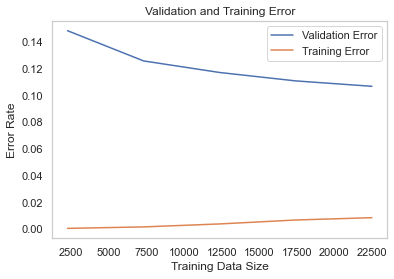

In [12]:
def error_scores(X, y, C=10, pen ='l2', slvr ='liblinear', tol=0.1):
    LR = LogisticRegression(C=C, penalty=pen, solver=slvr, tol=tol)
    LR.fit(X,y)
    
    size, scores_trn, scores_val = learning_curve(estimator=LR,
                                                  X=X,
                                                  y=y,
                                                  cv=10,
                                                  scoring="accuracy")
    errors_trn = 1-np.mean(scores_trn, axis=1)
    errors_val = 1-np.mean(scores_val, axis=1)
    output_df  = pd.DataFrame({"Training Size"   : size,
                               "Training Error"  : errors_trn,
                               "Validation Error": errors_val})
    return output_df

all_scores = error_scores(BOW_train_norm,y_train)
scores_val = all_scores['Validation Error']
scores_trn = all_scores['Training Error']
size       = all_scores['Training Size']

sns.set(font_scale = 1)
sns.set_style("whitegrid", {'axes.grid' : False})

plt.plot(size, scores_val, label='Validation Error')
plt.plot(size, scores_trn, label='Training Error')

plt.title ("Validation and Training Error")
plt.xlabel('Training Data Size')
plt.ylabel('Error Rate')
plt.legend()
plt.show()

#### The plot above shows that validation error -- which represents the model's potential to perform on unseen data -- continually decreases as the size of the training data increases. Meanwhile, the training error is consistently very low. This combination of high variance and low bias indicates overfitting. Given the downward trend of the validation error with increasing training size, the ability of the model to generalize to unseen data could likely be improved with additional data. This overfitting is why there is a difference between the training and testing scores. Moreover, the training and testing data we are given are equal in size. Train/test splits typically result in much more training data than testing data -- i.e., something like an 80/20 split, rather than 50/50. So it seems like we could afford to take some of the current testing data and include it in the training process, because we probably don't need as much data for testing, and the model could benefit from more training examples.

#### For me, the biggest takeaway from this assignment is that we need multiple ways to measure the model's success, because a single score doesn't capture all of the relevant information.